<h2 align=center>Generate Synthetic Images with DCGANs in Keras</h2>

### Project: [link](https://www.coursera.org/projects/generative-adversarial-networks-keras)

#### student: Pablo Benayas

## Task 1: Project Overview and Import Libraries

In [16]:
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
import numpy as np
import plot_utils
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython import display
print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.0.0


## Task 2: Load and Preprocess the Data

In [17]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data() 

# data preprocessing
X_train = X_train.astype(np.float32) / 255.0
X_test = X_test.astype(np.float32) / 255.0

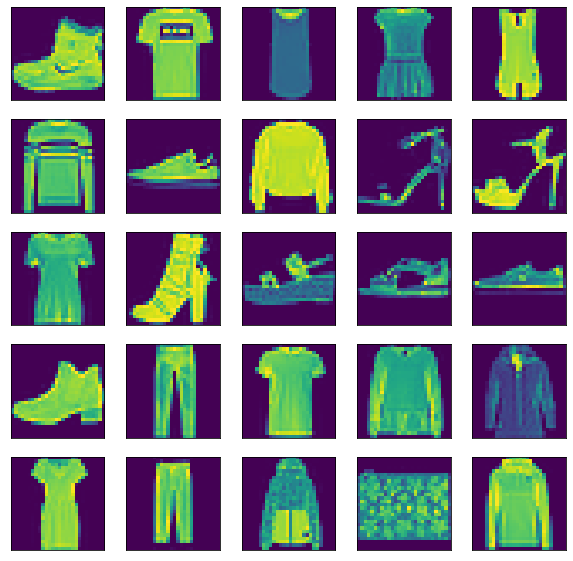

In [18]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i]) 

## Task 3: Create Batches of Training Data

In [19]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1) 

## Task 4: Build the Generator Network for DCGAN

![GAN](DCGAN.png)

**Generator** is an upsampling network with fractionally-strided convolutions

**Discriminator** is a convolutional network

Architecture guidelines for stable Deep Convolutional GANs:

- Replace any pooling layers with strided convolutions (discriminator) and fractional-strided convolutions (generator).
- Use batchnorm in both the generator and the discriminator.
- Remove fully connected hidden layers for deeper architectures.
- Use ReLU activation in generator for all layers expect for the output, which uses Tanh.
- Use LeakyReLU activation in the discriminator for all layers.

[Source](https://arxiv.org/pdf/1511.06434.pdf): Radford et al, "*Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks*", ICLR 2016

In [20]:
# generator model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
num_features = 100

generator = Sequential([
                Dense(7 * 7 * 128, input_shape=[num_features]),
                Reshape([7, 7, 128]),
                BatchNormalization(),
                Conv2DTranspose(64, (5,5), (2,2), padding='same', activation='selu'),
                BatchNormalization(),
                Conv2DTranspose(1, (5,5), (2,2), padding='same', activation='tanh')
]) 


# Why do we use batch normalization?
# We normalize the input layer by adjusting and scaling the activations. For example, 
# when we have features from 0 to 1 and some from 1 to 1000, we should normalize them 
# to speed up learning. If the input layer is benefiting from it, why not do the same 
# thing also for the values in the hidden layers, that are changing all the time, and 
# get 10 times or more improvement in the training speed.

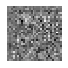

In [21]:
# generate a random picture. NO training here.
noise = tf.random.normal(shape=[1, num_features]) #one image at the time
generated_image = generator(noise,  training=False)
plot_utils.show(generated_image, 1)

In [22]:
generated_image.shape

TensorShape([1, 28, 28, 1])

## Task 5: Build the Discriminator Network for DCGAN

In [23]:
# discriminator model (IT IS LIKE CREATING AN IMAGE CLASSIFIER)
discriminator = Sequential([
                Conv2D(64, (5,5), (2,2), padding='same', input_shape=[28,28,1]), 
                    # input_shape -> generated_image.shape: TensorShape([1, 28, 28, 1]) 
                    # number of filters used, filter window dim and stride
                LeakyReLU(0.2),
                Dropout(0.3),
                Conv2D(128, (5,5), (2,2), padding='same'),
                LeakyReLU(0.2),
                Dropout(0.3),
                Flatten(),
                Dense(1, activation='sigmoid')
]) 

In [24]:
# discriminator model is untrained. That's why images will be 50% likely of being fake

decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.500146]], shape=(1, 1), dtype=float32)


## Task 6: Compile the Deep Convolutional Generative Adversarial Network (DCGAN)

In [25]:
discriminator.compile(loss='binary_crossentropy', optimizer='rmsprop') 
discriminator.trainable = False
gan = Sequential([generator, discriminator])
gan.compile(loss='binary_crossentropy', optimizer='rmsprop') 

## Task 7: Define Training Procedure

In [26]:
seed = tf.random.normal(shape=[batch_size, 100])
# 100 refers to the number of features

In [37]:
def train_dcgan(gan, dataset, batch_size, num_features, epochs=5):
    generator, discriminator = gan.layers
    for epoch in tqdm(range(epochs)):
        # tqdm() shows the progress, the time we have remaining and how long 
        # it takes to finish each epoch    
        print('Epoch: {}/{}'.format(epoch+1, epochs))
        for X_batch in dataset:
            noise = tf.random.normal(shape=[batch_size, num_features])
            generated_images = generator(noise) # fake images are created. as much fake images 
                # as real ones (X_batch size)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0) 
                # we are including fake images in the new dataset 
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
                # this is a vector that labels fake (generated_image -> 0) and real (X_batch -> 1)
                #IMPORTANT: size generated_images == size X_batch == batch_size
                #order matters: tf.concat([generated_images, X_batch])
            discriminator.trainable = True # we want it to learn
            discriminator.train_on_batch(X_fake_and_real, y1) # training discriminator network
                # X_fake_and_real -> X_train; y1-> y_train (the labels)
            y2 = tf.constant([[1.]] * batch_size) # class 1 refers to real images
                # class 0 is not included because we want to ignore fake images
            discriminator.trainable = False 
                # IMPORTANT: discriminator is already included in 'gan'!! 
                # Discriminator has already been trained before! We dont want to retrain it 
                    # with one class out of two
                # reminder: gan is a pipeline of generator and discriminator
            gan.train_on_batch(noise, y2) # in generator we use 'noise', in discriminator 
                # we use class 2, because we want to select random pictures that are treated
                # as real by the discriminator netowrk, which was trained lines above.
        
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch+1, seed) # out of all the randomly generated
            #images, we select the one passing the discriminator criteria
    
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

In [38]:
## Source https://www.tensorflow.org/tutorials/generative/dcgan#create_a_gif
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(10,10))
    
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='binary')
        plt.axis('off')
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

## Task 8: Train DCGAN

In [39]:
X_train_dcgan = X_train.reshape(-1,28,28,1) * 2 - 1 

In [40]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train_dcgan).shuffle(1000)
# batching dataset
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1) 

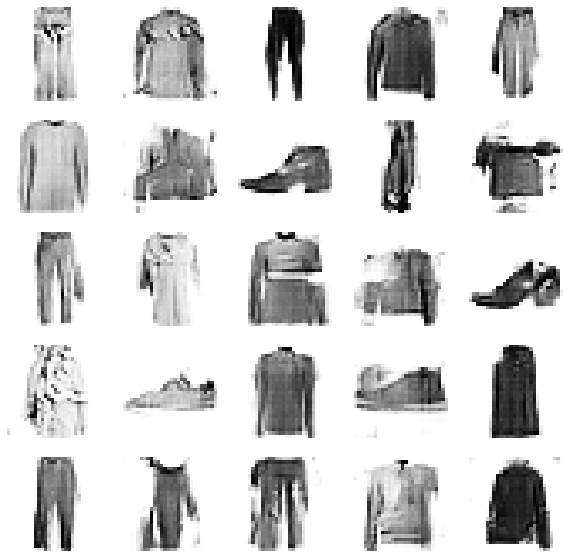

Wall time: 2h 11min 24s


In [41]:
%%time
train_dcgan(gan, dataset, batch_size, num_features, epochs=10)

## Task 9: Generate Synthetic Images with DCGAN

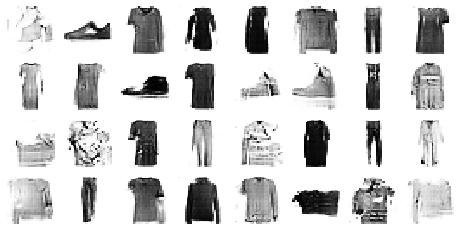

In [60]:
# Once our model is trained, let´s create some samples
noise = tf.random.normal(shape=[batch_size, num_features]) # we create batch_size 
                                                           # (which is a number) images
generated_images = generator(noise) # default: training=True

import numpy as np
import matplotlib.pyplot as plt

def show(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

show(images=generated_images, n_cols=8) 

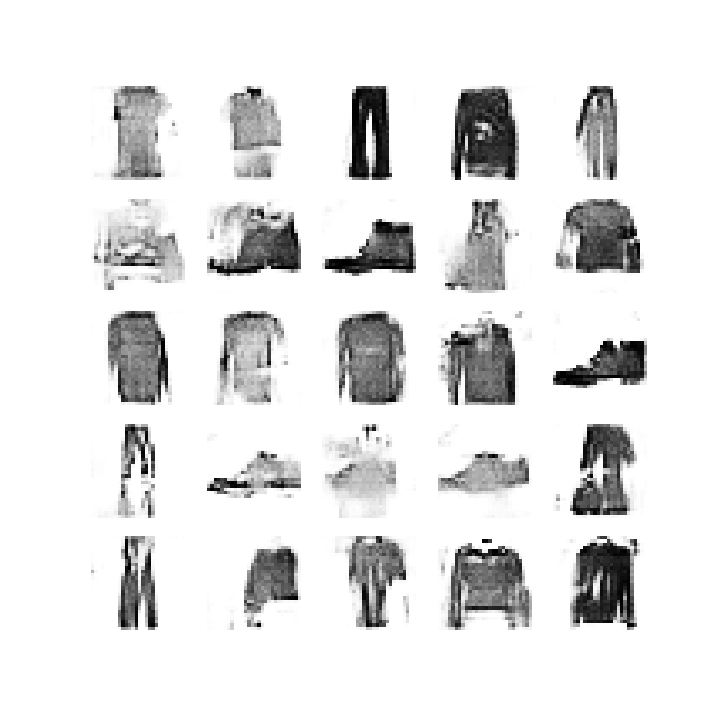

In [59]:
## Source: https://www.tensorflow.org/tutorials/generative/dcgan#create_a_gif

import imageio
import glob

anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

import IPython
display.Image(filename=anim_file)